In [1]:
import os
import sys

In [2]:
sys.path.append("..")

In [3]:
import numpy as np

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
from tqdm import tqdm
from collections import defaultdict

In [6]:
import glob

In [7]:
import matplotlib.pyplot as plt

In [8]:
embeddings_path = "/home/alexey/Documents/python/household/embeddings"

In [9]:
crop_size = "2sec"

In [29]:
data = np.load(f"{embeddings_path}/emb_vox1_train_clova_{crop_size}.npz")


X = torch.tensor(data['X'])
utt_ids = data['ids']

spk_ids = [utt.split('-')[0] for utt in utt_ids]

X = F.normalize(X, dim=1)

classes, y = np.unique(spk_ids, return_inverse=True)
y = torch.tensor(y).long()
classes, y = torch.unique(y, return_inverse=True)

print('classes:', len(classes))
print(X.shape, y.shape)

# # filter out small classes
# classes, counts = torch.unique(y, return_counts=True)
# classes_subset = classes[counts > 100]

# mask = y == -1
# for c in classes_subset:
#     mask = (y == c) + (mask)

# X = X[mask]
# y = y[mask]
# classes, _ = torch.unique(y, return_inverse=True)

# print('classes:', len(classes))
# print(X.shape, y.shape)    

classes: 1211
torch.Size([148642, 512]) torch.Size([148642])


In [30]:
torch.sort(torch.unique(y, return_counts=True)[1])[::10]

(tensor([  45,   45,   45,  ...,  589,  656, 1002]),)

In [31]:
# train / test split
test_fraction = 0.25

perm = torch.randperm(len(classes))
n = int(test_fraction * len(classes))
classes_test = classes[perm][:n]
classes_train = classes[perm][n:]

mask_train = y == -1
for c in classes_train:
    mask_train = (mask_train) + (y == c)

X_train = X[mask_train]    
y_train = y[mask_train] 

X = X[torch.logical_not(mask_train)] 
y = y[torch.logical_not(mask_train)] 

print(X_train.shape, X.shape)

torch.Size([111345, 512]) torch.Size([37297, 512])


In [32]:
from utils import generate_trials

n_tar, n_imp = 50000, 50000

trials_1vs1, labels_1vs1 = generate_trials(y, n_tar, n_imp, n_enrolls=1, n_tests=1, seed=0)
print('.')
trials_3vs1, labels_3vs1 = generate_trials(y, n_tar, n_imp, n_enrolls=3, n_tests=1, seed=1)
print('..')
trials_10vs1, labels_10vs1 = generate_trials(y, n_tar, n_imp, n_enrolls=10, n_tests=1, seed=2)
print('...')

.
..
...


In [33]:
trials_1vs1[:3], trials_3vs1[:3], trials_10vs1[:3]

([(tensor([11576]), tensor([11509])),
  (tensor([32135]), tensor([32162])),
  (tensor([4396]), tensor([4405]))],
 [(tensor([35755, 35895, 36064]), tensor([35762])),
  (tensor([16512, 16556, 16516]), tensor([16587])),
  (tensor([29991, 29912, 30010]), tensor([29955]))],
 [(tensor([28211, 28285, 28238, 28269, 28349, 28225, 28298, 28329, 28277, 28304]),
   tensor([28226])),
  (tensor([16270, 16261, 16243, 16264, 16213, 16241, 16223, 16255, 16258, 16245]),
   tensor([16224])),
  (tensor([24576, 24588, 24573, 24583, 24582, 24599, 24594, 24587, 24568, 24578]),
   tensor([24602]))])

In [34]:
from scoring import *
from utils import requires_grad
from metrics import eer

In [36]:
outputs = []

for idx, score_type in enumerate(['cos_emb_avg', 'cos_sc_avg', 'plda_sph']):

    if score_type == 'cos_emb_avg':
        similarity_score = ScoreCosine('embeddings')
    elif score_type == 'cos_sc_avg':
        similarity_score = ScoreCosine('scores')
    elif score_type == 'plda_sph':
        from training import train_plda_sph_mle
        b, w = train_plda_sph_mle(X_train, y_train)
        similarity_score = ScoreSphPLDA(b, w, by_the_book=True)
        
    requires_grad(similarity_score, False)
    
    # compute scores
    # 1 enroll
    scores_1vs1 = []
    for (idx_enr, idx_test) in tqdm(trials_1vs1):

        x_enr = X[idx_enr]
        x_test = X[idx_test:idx_test+1]

        score = similarity_score(x_enr, x_test)
        scores_1vs1 += [score]

    scores_1vs1 = torch.cat(scores_1vs1)
    scores_1vs1 = scores_1vs1.cpu().numpy()

    # 3 enrolls
    scores_3vs1 = []
    for (idx_enr, idx_test) in tqdm(trials_3vs1):

        x_enr = X[idx_enr]
        x_test = X[idx_test:idx_test+1]

        score = similarity_score(x_enr, x_test)
        scores_3vs1 += [score]

    scores_3vs1 = torch.cat(scores_3vs1)
    scores_3vs1 = scores_3vs1.cpu().numpy()

    #10 enrolls
    scores_10vs1 = []
    for (idx_enr, idx_test) in tqdm(trials_10vs1):

        x_enr = X[idx_enr]
        x_test = X[idx_test:idx_test+1]

        score = similarity_score(x_enr, x_test)
        scores_10vs1 += [score]

    scores_10vs1 = torch.cat(scores_10vs1)
    scores_10vs1 = scores_10vs1.cpu().numpy()
    
    # compute EER
    EER, _ = eer(np.r_[scores_1vs1, scores_3vs1, scores_10vs1], np.r_[labels_1vs1, labels_3vs1, labels_10vs1])
    #EER, _ = eer(np.r_[scores_1vs1, scores_10vs1], np.r_[labels_1vs1, labels_10vs1])
    print(f'EER, {score_type}, pooled: {100*EER:.2f} %') 
    EER, _ = eer(scores_1vs1, labels_1vs1)
    print(f'EER, {score_type}, 1 enroll: {100*EER:.2f} %')
    EER, _ = eer(scores_3vs1, labels_3vs1)
    print(f'EER, {score_type}, 3 enrolls: {100*EER:.2f} %')
    EER, _ = eer(scores_10vs1, labels_10vs1)
    print(f'EER, {score_type}, 10 enrolls: {100*EER:.2f} %')
        
    
#     n_bins = 100
#     ax[idx].hist(scores_1vs1[labels_1vs1==1], bins=n_bins, color='c', density=True, alpha=0.3, label='tar 1');
#     ax[idx].hist(scores_3vs1[labels_3vs1==1], bins=n_bins, color='b', density=True, alpha=0.3, label='tar 3');
#     ax[idx].hist(scores_10vs1[labels_10vs1==1], bins=n_bins, color='k', density=True, alpha=0.3, label='tar 10');
#     ax[idx].hist(scores_1vs1[labels_1vs1==0], bins=n_bins, color='r', density=True, alpha=0.3, label='imp 1');
#     ax[idx].hist(scores_10vs1[labels_10vs1==0], bins=n_bins, color='m', density=True, alpha=0.3, label='imp 10');
#     #ax[idx].title(f'{score_type} {crop_size}');
#     ax[idx].legend();
    
    
    outputs += [(scores_1vs1, scores_3vs1, scores_10vs1)]

  1%|          | 1155/100000 [00:00<00:08, 11547.92it/s]

EER, cos_emb_avg, pooled: 3.10 %
EER, cos_emb_avg, 1 enroll: 3.51 %
EER, cos_emb_avg, 3 enrolls: 1.36 %
EER, cos_emb_avg, 10 enrolls: 0.79 %


100%|██████████| 100000/100000 [00:17<00:00, 5634.90it/s]


EER, cos_sc_avg, pooled: 2.00 %
EER, cos_sc_avg, 1 enroll: 3.51 %
EER, cos_sc_avg, 3 enrolls: 1.47 %
EER, cos_sc_avg, 10 enrolls: 0.90 %


  0%|          | 0/100000 [00:00<?, ?it/s]../scoring_impl.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b, w = torch.tensor(b), torch.tensor(w)
100%|██████████| 100000/100000 [00:53<00:00, 1881.49it/s]


EER, plda_sph, pooled: 1.91 %
EER, plda_sph, 1 enroll: 3.51 %
EER, plda_sph, 3 enrolls: 1.34 %
EER, plda_sph, 10 enrolls: 0.80 %


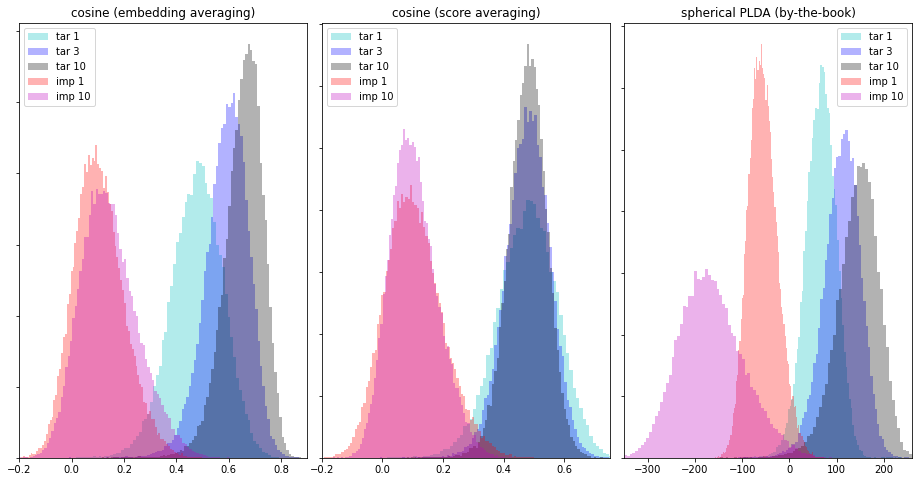

In [50]:
fig = plt.figure(figsize=(16, 8))
ax = fig.subplots(1, 3)


titles = ["cosine (embedding averaging)", "cosine (score averaging)", "spherical PLDA (by-the-book)"]


for idx, (scores_1vs1, scores_3vs1, scores_10vs1) in enumerate(outputs):
    
    if idx == 0:
        ax[idx].set(xlim=(-0.2, 0.9))
    elif idx == 1:
        ax[idx].set(xlim=(-0.2, 0.75))
    else:
        ax[idx].set(xlim=(-350, 260))
    
    n_bins = 100
    ax[idx].hist(scores_1vs1[labels_1vs1==1], bins=n_bins, color='c', density=True, alpha=0.3, label='tar 1');
    ax[idx].hist(scores_3vs1[labels_3vs1==1], bins=n_bins, color='b', density=True, alpha=0.3, label='tar 3');
    ax[idx].hist(scores_10vs1[labels_10vs1==1], bins=n_bins, color='k', density=True, alpha=0.3, label='tar 10');
    ax[idx].hist(scores_1vs1[labels_1vs1==0], bins=n_bins, color='r', density=True, alpha=0.3, label='imp 1');
    ax[idx].hist(scores_10vs1[labels_10vs1==0], bins=n_bins, color='m', density=True, alpha=0.3, label='imp 10');
    ax[idx].set_title(titles[idx]);
    ax[idx].legend();
    
    ax[idx].set_yticklabels([])
    #ax[idx].set_xticklabels([])

plt.subplots_adjust(wspace=0.05, hspace=0)

plt.savefig("fig/clova_multienroll_hist.pdf", bbox_inches="tight", dpi=300)